In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pprint import pprint
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.iolib import SimpleTable
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt, het_white, het_arch, acorr_ljungbox
from statistics import *
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit
from scipy.stats.stats import kurtosis, skew
from scipy.stats import boxcox
from IPython.core.display import display
from patsy import dmatrices
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from arch.univariate import ARX, ARCH, GARCH
import warnings
from datetime import datetime, timedelta
import seaborn as sns
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 15

def read_csv(*args, **kwargs):
    kwargs.setdefault('parse_dates', True)
    kwargs.setdefault('index_col', 'Date')
    return pd.read_csv(*args, **kwargs)

In [2]:
# Индекс реального эффективного курса рубля, инвестиции в основной капитал, ставки на рыынки межбанковских кредитов

In [3]:
# Индекс РСТ
rtsi_df = read_csv('data/RTSI.csv')
rtsi_series = rtsi_df.Close

# S&P500
sp500_df = read_csv('data/SP500.csv')
sp500_series = sp500_df.Close

# FTSE - Англия
ftse_df = read_csv('data/FTSE.csv')
ftse_series = ftse_df.Close

# DAX - Германия
dax_df = read_csv('data/DAX.csv')
dax_series = dax_df.Close

# SSE - Китай
sse_df = read_csv('data/SSE.csv')
sse_series = sse_df.Close

# Нефть Brent
brent_df = read_csv('data/BRENT.csv')
brent_series = brent_df.Close

# USD/RUB
usd_df = read_csv('data/USD.csv')
usd_series = usd_df.Close

# Темпы роста ВВП РФ
gdp_df = read_csv('data/GDP.csv')
gdp_series = gdp_df.Close

# Золото
gold_df = read_csv('data/GOLD.csv')
gold_series = gold_df.Close

# Уровень безработицы
unemployment_df = read_csv('data/UNEMPLOYMENT.csv')
unemployment_series = unemployment_df.Close

all_df = pd.DataFrame({
    'RTSI': rtsi_series,
    'SP500': sp500_series,
    'FTSE': ftse_series,
    'DAX': dax_series,
    'SSE': sse_series,
    'Brent': brent_series,
    'USD': usd_series,
    'GDP': gdp_series,
    'Gold': gold_series,
    'Unemployment': unemployment_series
})

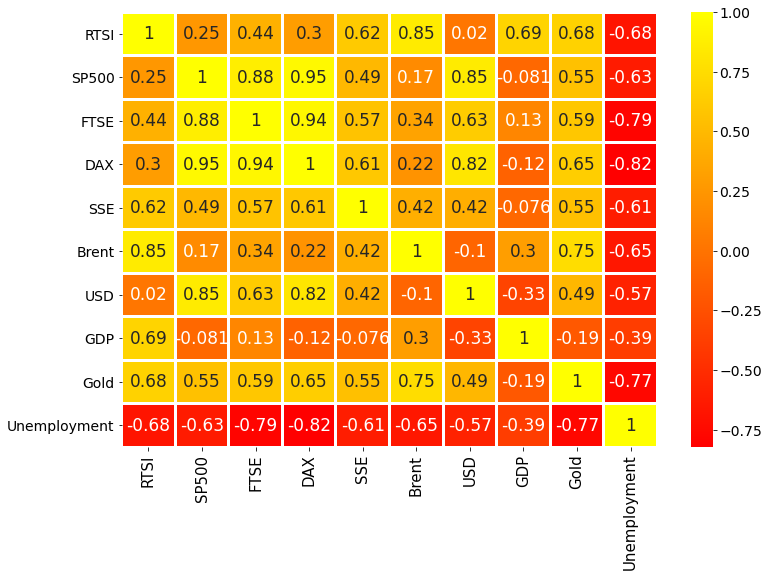

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(all_df.corr(), cmap='autumn', annot=True, linewidths=2, ax=ax, annot_kws={'size': 17});